# RL Controller Training and Testing
This notebook demonstrates the training and evaluation of an RL agent for microgrid control.

## Importing Libraries and Setup

In [1]:
import sys, os
import pandas as pd

from stable_baselines3.common.monitor import Monitor

# Path setup
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import simulation components
from microgrid_sim.core.gym_wrapper import MicrogridGymEnv
from microgrid_sim.control.rl_controller import RLController
from microgrid_sim.data import SyntheticDataBuilder
from microgrid_sim.utils import plot_simulation, plot_reward_progress
from microgrid_sim.components.generators import PVGenerator, WindTurbine, FossilGenerator, GridIntertie
from microgrid_sim.components.storage import BatteryStorage
from microgrid_sim.components.loads import ResidentialLoad, FactoryLoad
from microgrid_sim.core.environment import MicrogridEnv
from microgrid_sim.control import RuleBasedEMS
from microgrid_sim.control.rules import BatteryRule, DieselRule, GridRule, TimeSchedule, RenewableDisconnectRule

print("Imports OK")

Imports OK


## Configuration

In [2]:
# --- Global Constants ---
NO_OF_EPISODES = 50
TOTAL_HOURS = 24 * 3  # Total data available
CONTROL_DT = 60  # Control interval in minutes
SIM_DT = 1  # Simulation timestep in minutes
SEED = 42

# --- Training Parameters (Light training for quick testing) ---
CONTROL_STEPS_PER_EP = (TOTAL_HOURS * 60) // CONTROL_DT  # 24 steps per episode
TRAINING_TIMESTEPS = CONTROL_STEPS_PER_EP * NO_OF_EPISODES
EVAL_FREQ = CONTROL_STEPS_PER_EP * (NO_OF_EPISODES / 10) # Evaluate 5 times during training
N_EVAL_EPISODES = 1

# Paths
MODEL_DIR = "./models"
LOG_DIR = "./logs/ppo_training"
RESULTS_DIR = "./plots/05_rl_testing"

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print("Configuration complete.")
print(f"Control steps per episode: {CONTROL_STEPS_PER_EP}")
print(f"Total training timesteps: {TRAINING_TIMESTEPS}")


Configuration complete.
Control steps per episode: 72
Total training timesteps: 3600


## Data Generation Helpers

In [3]:
def setup_data_builder(seed: int) -> SyntheticDataBuilder:
    """Creates a configured data builder."""
    builder = SyntheticDataBuilder(
        total_hours=TOTAL_HOURS,
        sim_dt_minutes=SIM_DT,
        seed=seed
    )

    # Add components - MUST match MicrogridEnv component names
    builder.add_pv("pv_1", peak_irr=900)
    builder.add_pv("pv_2", peak_irr=500)
    builder.add_wind("wind_a", mean_speed=6.0)
    builder.add_load("factory_a", base_kw=10.0, profile="factory")
    builder.add_load("factory_b", base_kw=5.0, profile="factory")
    builder.add_load("house_a", base_kw=1.5, profile="residential")
    builder.add_load("house_b", base_kw=1.5, profile="residential")
    builder.add_load("house_c", base_kw=1.5, profile="residential")
    builder.add_grid_prices("grid")

    return builder


def setup_microgrid_env() -> MicrogridEnv:
    """Creates a configured MicrogridEnv with all components."""
    env = MicrogridEnv(
        simulation_hours=TOTAL_HOURS,
        control_interval_minutes=CONTROL_DT,
        sim_dt_minutes=SIM_DT
    )

    # --- Add Components (names must match data builder) ---
    pv1 = PVGenerator(
        "pv_1", capacity_kw=12.0,
        time_step_minutes=SIM_DT,
        maintenance_cost_per_kwh=0.02,
        )
    pv2 = PVGenerator(
        "pv_2", capacity_kw=8.0,
        time_step_minutes=SIM_DT,
        maintenance_cost_per_kwh=0.02,
        )

    wind_a = WindTurbine(
        "wind_a", rated_kw=12.5,
        time_step_minutes=SIM_DT,
        maintenance_cost_per_kwh=0.027,
        )

    diesel1 = FossilGenerator("diesel_1", p_min_kw=2.0, p_max_kw=12.0,
                             time_step_minutes=SIM_DT,
                             fuel_cost_per_kwh=0.45, # ~1.66 SAR/L × 0.27 L/kWh
                             maintenance_cost_per_hour=1.0, # Big set
                             )
    diesel2 = FossilGenerator("diesel_2", p_min_kw=0.0, p_max_kw=7.5,
                             time_step_minutes=SIM_DT,
                             fuel_cost_per_kwh=0.45, # ~1.66 SAR/L × 0.27 L/kWh
                             maintenance_cost_per_hour=0.4, # Smaller set
                             )

    house_a = ResidentialLoad("house_a", base_kw=2.5, noise_std=0.15)
    house_b = ResidentialLoad("house_b", base_kw=1.5, noise_std=0.2)
    house_c = ResidentialLoad("house_c", base_kw=1.5, noise_std=0.1)

    factory_a = FactoryLoad("factory_a", base_kw=14.0, noise_std=0.5)
    factory_b = FactoryLoad("factory_b", base_kw=8.5, noise_std=0.25)

    bat1 = BatteryStorage("bat_1", capacity_kwh=25.0,
                        time_step_minutes=SIM_DT,
                        max_charge_kw=5.0,
                        max_discharge_kw=5.0,
                        degradation_cost_per_kwh=0.086,
                        )
    bat2 = BatteryStorage("bat_2", capacity_kwh=5.0,
                        time_step_minutes=SIM_DT,
                        max_charge_kw=1.0,
                        max_discharge_kw=1.0,
                        degradation_cost_per_kwh=0.086,
                        )

    grid = GridIntertie("grid", time_step_minutes=SIM_DT,
                       import_limit_kw=20.0,
                       export_limit_kw=15.0,
                       price_export_per_kwh=0.20,
                       price_import_per_kwh=0.20
                       )

    # Add all components
    for c in [pv1, pv2, wind_a, diesel1, diesel2, house_a, house_b, house_c,
              factory_a, factory_b, bat1, bat2]:
        env.add_component(c)

    env.add_component(grid, is_grid=True)

    return env


def setup_ems_controller() -> RuleBasedEMS:
    """Sets up a simple, heuristic EMS for baseline comparison."""
    rules = [
        BatteryRule(
            name="bat_1",
            charge_schedule=TimeSchedule(11, 15),
            discharge_schedule=TimeSchedule(18, 22),
            charge_kw=-8.0,
            discharge_kw=8.0
        ),
        DieselRule(
            name="diesel_1",
            run_schedule=TimeSchedule(22, 6),
            setpoint_kw=5.0
        ),
        GridRule(name="grid"),
        RenewableDisconnectRule(name="pv_1"),
        RenewableDisconnectRule(name="pv_2"),
        RenewableDisconnectRule(name="wind_a"),
    ]
    return RuleBasedEMS(rules=rules)

print("Helper functions defined.")

Helper functions defined.


## Data and Environment Setup

In [4]:
# Reward Function Weights

reward_weights={
    "cost": 50.0,
    "unmet": 50.0,
    "curtailment": 1.0,
    "soc_deviation": 0.0,
}

In [5]:
print("\n=== Setting up environments ===")

# 1. Create MicrogridEnv instances (separate for train/eval)
base_env_train = setup_microgrid_env()
base_env_eval = setup_microgrid_env()
base_env_test = setup_microgrid_env()

# 2. Create Data Builders (different seeds for train/eval)
data_builder_train = setup_data_builder(SEED)
data_builder_eval = setup_data_builder(SEED + 100)
data_builder_test = setup_data_builder(SEED + 200)

# 3. Create Gym Environments (Dict Action Space)
train_env_dict = MicrogridGymEnv(
    microgrid_env=base_env_train,
    data_builder=data_builder_train,
    reward_weights=reward_weights,
)

eval_env_dict = MicrogridGymEnv(
    microgrid_env=base_env_eval,
    data_builder=data_builder_eval,
    reward_weights=reward_weights,
)

test_env_dict = MicrogridGymEnv(
    microgrid_env=base_env_test,
    data_builder=data_builder_test,
    reward_weights=reward_weights,
)

# 4. Apply Flattener Wrapper for SB3 compatibility
train_env = train_env_dict.create_flattened_env()
eval_env = eval_env_dict.create_flattened_env()
test_env = test_env_dict.create_flattened_env()

train_monitor_path = os.path.join(LOG_DIR, "monitor_train")
eval_monitor_path  = os.path.join(LOG_DIR, "monitor_eval")

train_env = Monitor(train_env, filename=train_monitor_path)
eval_env  = Monitor(eval_env,  filename=eval_monitor_path)

print(f"\nOriginal Dict Action Space Keys: {list(train_env_dict.action_space.keys())}")
print(f"Flattened Box Action Space: {train_env.action_space}")
print(f"Observation Space Keys: {list(train_env_dict.observation_space.keys())}")
print("\nEnvironments created successfully.")


=== Setting up environments ===

Original Dict Action Space Keys: ['bat_1_mag', 'bat_1_mode', 'bat_2_mag', 'bat_2_mode', 'diesel_1_on', 'diesel_1_sp', 'diesel_2_on', 'diesel_2_sp', 'grid_mode', 'grid_trade', 'pv_1_con', 'pv_2_con', 'wind_a_con']
Flattened Box Action Space: Box(-1.0, 1.0, (24,), float32)
Observation Space Keys: ['bat_1_soc', 'bat_2_soc', 'diesel_1_p', 'diesel_2_p', 'factory_a_l', 'factory_b_l', 'grid_p_exp', 'grid_p_imp', 'house_a_l', 'house_b_l', 'house_c_l', 'pv_1_p', 'pv_2_p', 'wind_a_p']

Environments created successfully.


## Test Random Policy (Baseline)


=== Testing Random Policy (Baseline) ===
Random Policy - Steps: 72
Random Policy - Total Reward: -20113.80
Random Policy - Total Cost: $-200.32
Random policy baseline complete.



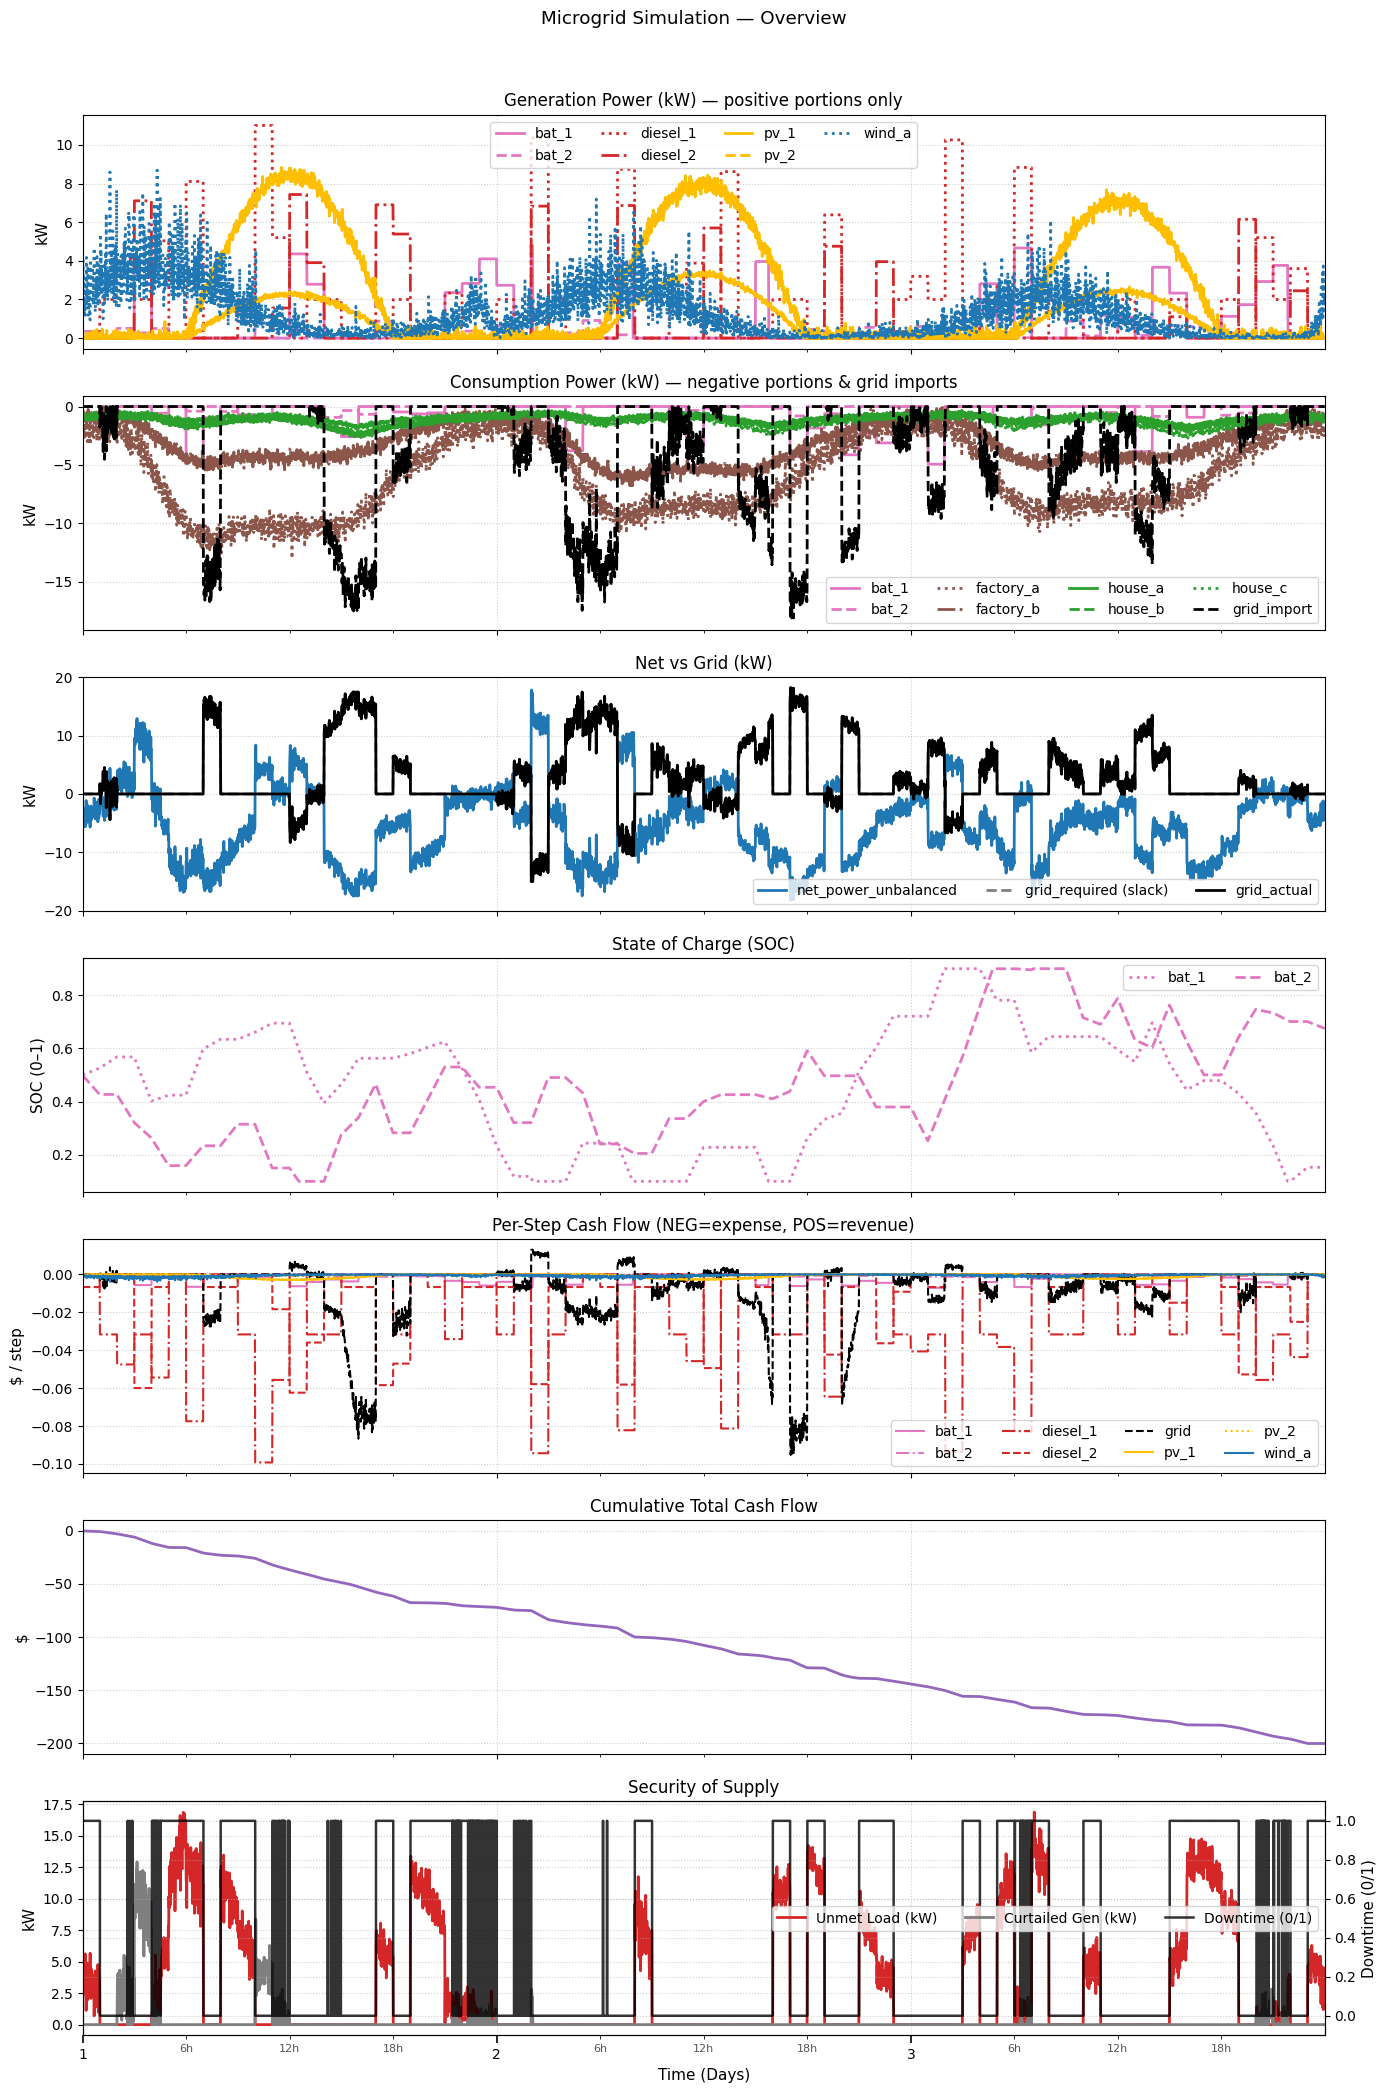

In [6]:
print("\n=== Testing Random Policy (Baseline) ===")

obs, info = test_env.reset(seed=SEED)
episode_reward = 0.0
done = False
step_count = 0

while not done:
    action = test_env.action_space.sample()
    obs, reward, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated
    episode_reward += reward
    step_count += 1

df_random = test_env.unwrapped.env.get_results(as_dataframe=True)
random_cost = df_random["total_cashflow"].sum()
random_reward = episode_reward

print(f"Random Policy - Steps: {step_count}")
print(f"Random Policy - Total Reward: {episode_reward:.2f}")
print(f"Random Policy - Total Cost: ${random_cost:.2f}")

# Plot
_ = plot_simulation(
    df_random,
    sim_dt_minutes=SIM_DT,
    sim_name="05-01_random_policy",
    save=True,
    base_dir=RESULTS_DIR
)

print("Random policy baseline complete.\n")

## Train RL Agent

In [7]:
print("\n=== Training RL Agent ===")

rl_controller = RLController(
    env=train_env,
    policy='MlpPolicy',
    learning_rate=3e-4,
    n_steps=CONTROL_STEPS_PER_EP,
    batch_size=12,
    n_epochs=5,
    verbose=0
)

rl_controller.train(
    total_timesteps=TRAINING_TIMESTEPS,
    log_dir=LOG_DIR,
    eval_env=eval_env,
    eval_freq=EVAL_FREQ,
    n_eval_episodes=N_EVAL_EPISODES,
)

# Save the trained model
model_path = os.path.join(MODEL_DIR, "ppo_microgrid")
rl_controller.save(model_path)


=== Training RL Agent ===


Output()

Eval num_timesteps=1800, episode_reward=-11282.23 +/- 0.00

Episode length: 72.00 +/- 0.00

New best mean reward!

Eval num_timesteps=3600, episode_reward=-5416.46 +/- 0.00

Episode length: 72.00 +/- 0.00

New best mean reward!

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'PPO — Evaluation Reward'}, xlabel='Episode', ylabel='Reward'>)

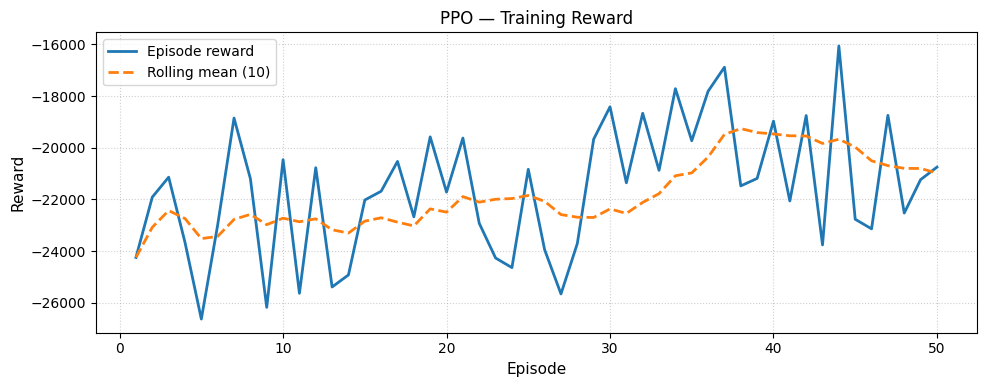

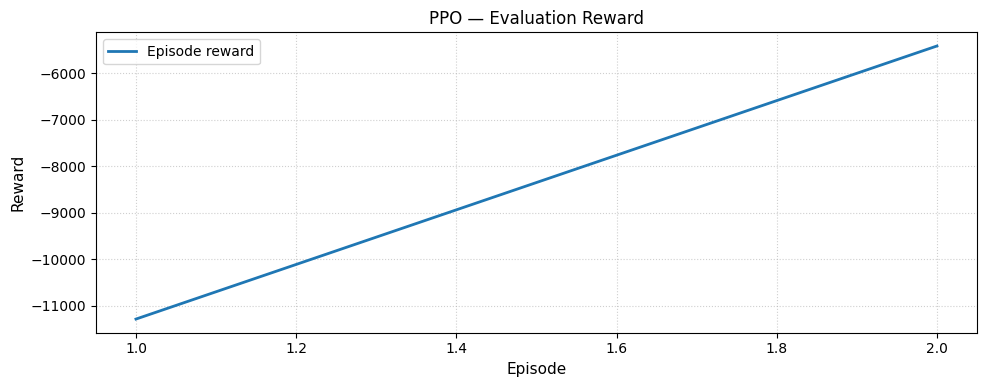

In [8]:
plot_reward_progress(
    f"{train_monitor_path}.monitor.csv",
    title="PPO — Training Reward",
    out_path=os.path.join(RESULTS_DIR, "ppo_reward_progress.png"),
    rolling=10
)

plot_reward_progress(
    f"{eval_monitor_path}.monitor.csv",
    title="PPO — Evaluation Reward",
    out_path=os.path.join(RESULTS_DIR, "ppo_eval_reward_progress.png"),
    rolling=10
)

## Evaluate Trained RL Agent


=== Evaluating Trained RL Agent ===
RL Policy - Steps: 72
RL Policy - Total Reward: -5458.27
RL Policy - Total Cost: $-109.15
RL policy evaluation complete.



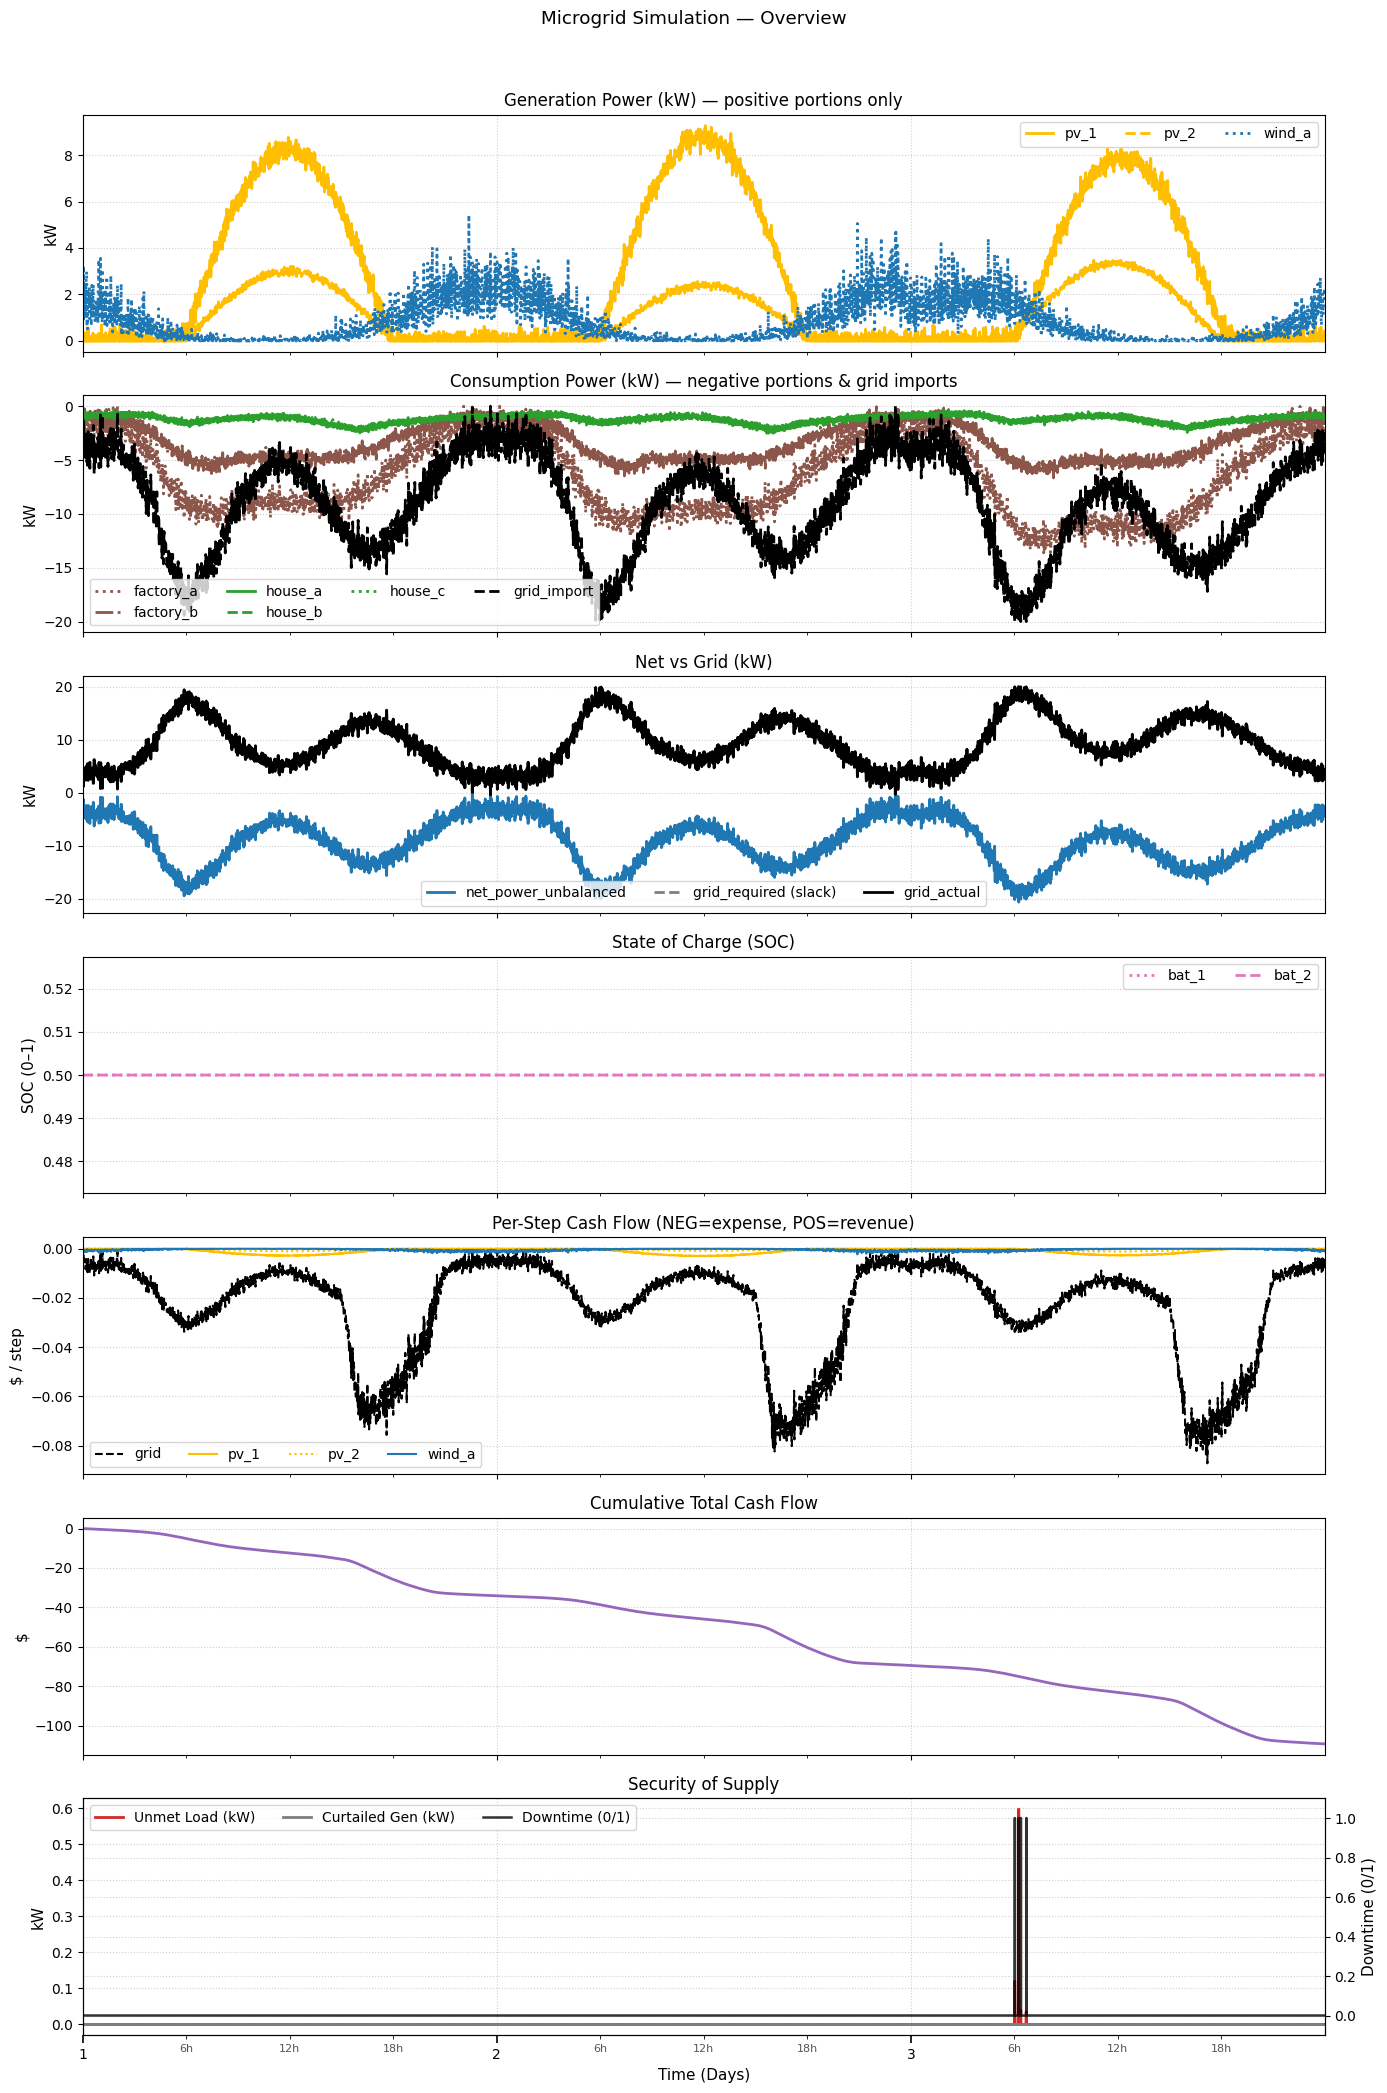

In [9]:
print("\n=== Evaluating Trained RL Agent ===")

obs, info = test_env.reset(seed=SEED)
episode_reward = 0.0
done = False
step_count = 0

while not done:
    action = rl_controller.decide(obs, deterministic=True)
    obs, reward, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated
    episode_reward += reward
    step_count += 1

df_rl = test_env.unwrapped.env.get_results(as_dataframe=True)
rl_cost = df_rl["total_cashflow"].sum()
rl_reward = episode_reward

print(f"RL Policy - Steps: {step_count}")
print(f"RL Policy - Total Reward: {episode_reward:.2f}")
print(f"RL Policy - Total Cost: ${rl_cost:.2f}")

# Plot
_ = plot_simulation(
    df_rl,
    sim_dt_minutes=SIM_DT,
    sim_name="05-02_rl_policy",
    save=True,
    base_dir=RESULTS_DIR
)

print("RL policy evaluation complete.\n")

## Compare with Rule-Based EMS


=== Evaluating Rule-Based EMS ===
Rule-Based EMS - Total Cost: $-182.36
Rule-based EMS evaluation complete.



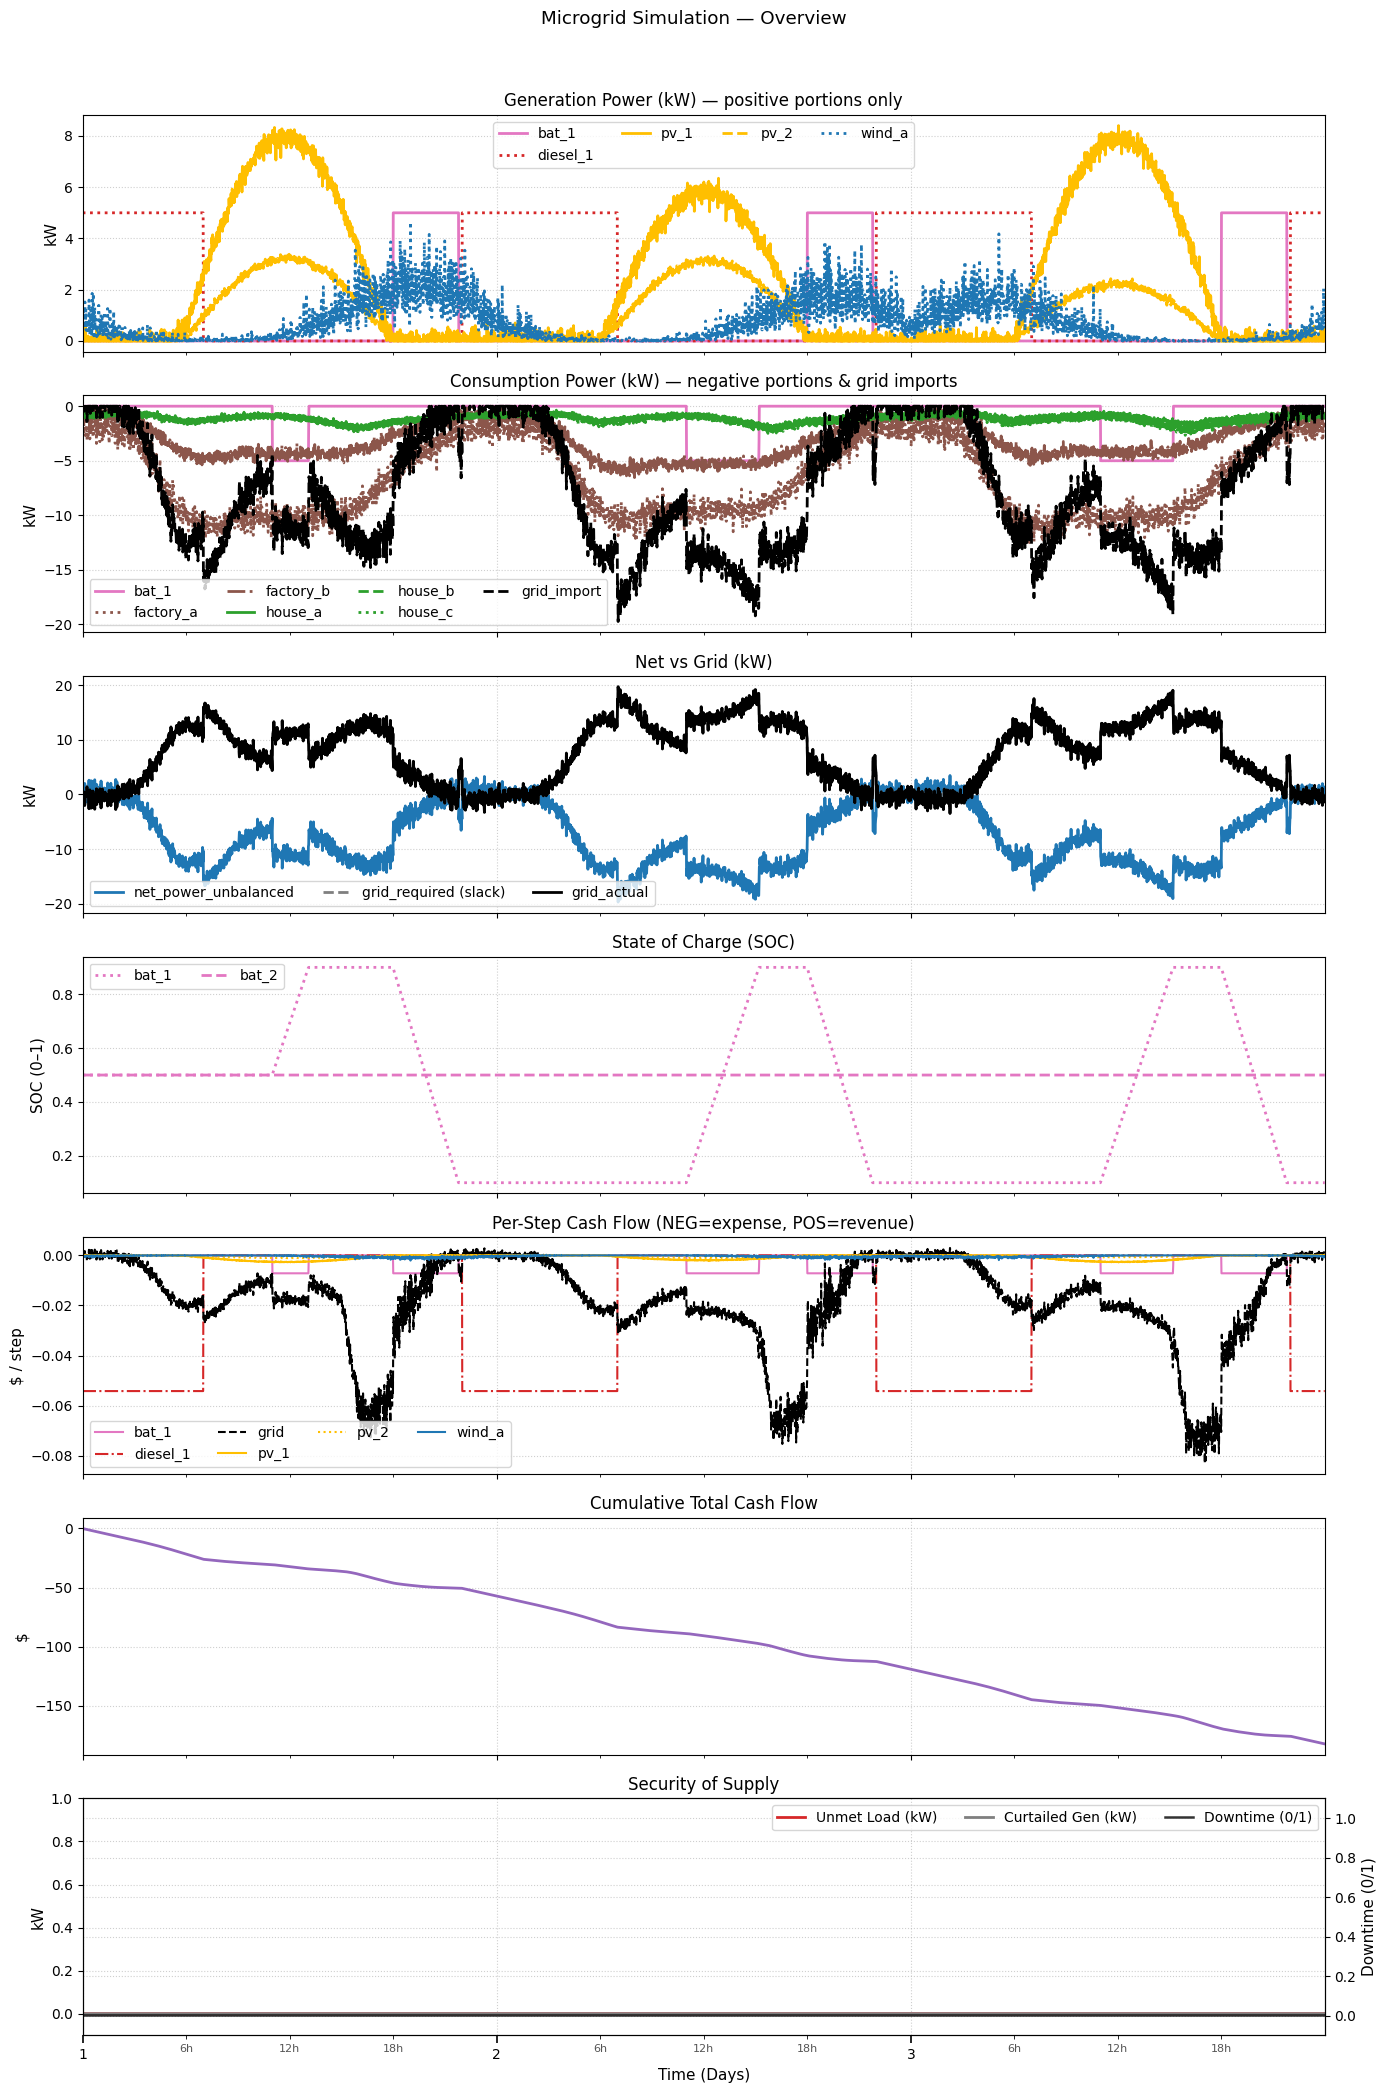

In [10]:
print("\n=== Evaluating Rule-Based EMS ===")

# Create fresh environment for rule-based test
base_env_test.reset()
exog_list_test = data_builder_test.build_list()

ems = setup_ems_controller()
base_env_test.run(controller=ems, exogenous_list=exog_list_test)

df_rule = base_env_test.get_results(as_dataframe=True)
rule_cost = df_rule["total_cashflow"].sum()

# Reward Calculation
dt_hours = SIM_DT / 60.0
rule_cash_flow = df_rule["total_cashflow"].sum()
rule_unmet_energy = df_rule["unmet_load_kw"].sum() * dt_hours
rule_curtailed_energy = df_rule["curtailed_gen_kw"].sum() * dt_hours
rule_reward = (
    rule_cash_flow * reward_weights["cost"]
    - rule_unmet_energy * reward_weights["unmet"]
    - rule_curtailed_energy * reward_weights["curtailment"]
)

print(f"Rule-Based EMS - Total Cost: ${rule_cost:.2f}")

# Plot
_ = plot_simulation(
    df_rule,
    sim_dt_minutes=SIM_DT,
    sim_name="05-03_rule_based_ems",
    save=True,
    base_dir=RESULTS_DIR
)

print("Rule-based EMS evaluation complete.\n")

## Performance Comparison

In [11]:
print("\n=== Performance Comparison ===")

dt_hours = SIM_DT / 60.0

# Calculate metrics
metrics = {
    "Random Policy": {
        "Total Cost ($)": random_cost,
        "Unmet Energy (kWh)": df_random["unmet_load_kw"].sum() * dt_hours,
        "Curtailed Energy (kWh)": df_random["curtailed_gen_kw"].sum() * dt_hours,
        "Test Reward": random_reward,
    },
    "Rule-Based EMS": {
        "Total Cost ($)": rule_cost,
        "Unmet Energy (kWh)": df_rule["unmet_load_kw"].sum() * dt_hours,
        "Curtailed Energy (kWh)": df_rule["curtailed_gen_kw"].sum() * dt_hours,
        "Test Reward": rule_reward,
    },
    "RL Policy": {
        "Total Cost ($)": rl_cost,
        "Unmet Energy (kWh)": df_rl["unmet_load_kw"].sum() * dt_hours,
        "Curtailed Energy (kWh)": df_rl["curtailed_gen_kw"].sum() * dt_hours,
        "Test Reward": rl_reward,
    }
}

# Create comparison table
comparison_df = pd.DataFrame(metrics).T
comparison_df["Total Cost ($)"] = comparison_df["Total Cost ($)"].apply(lambda x: f"${x:,.2f}")
comparison_df["Unmet Energy (kWh)"] = comparison_df["Unmet Energy (kWh)"].apply(lambda x: f"{x:.3f}")
comparison_df["Curtailed Energy (kWh)"] = comparison_df["Curtailed Energy (kWh)"].apply(lambda x: f"{x:.3f}")
comparison_df["Test Reward"] = comparison_df["Test Reward"].apply(lambda x: f"{x:.3f}")

print("\n" + "="*70)
print("🏆 CONTROLLER PERFORMANCE COMPARISON 🏆")
print("="*70)
print(comparison_df.to_string())
print("\nNote: Negative costs are expenses. Lower absolute value is better.")
print("="*70)


=== Performance Comparison ===

🏆 CONTROLLER PERFORMANCE COMPARISON 🏆
               Total Cost ($) Unmet Energy (kWh) Curtailed Energy (kWh) Test Reward
Random Policy        $-200.32            201.582                 18.440  -20113.803
Rule-Based EMS       $-182.36              0.000                  0.000   -9118.081
RL Policy            $-109.15              0.015                  0.000   -5458.269

Note: Negative costs are expenses. Lower absolute value is better.


## Load and Test Saved Model

In [12]:
print("\n=== Testing Model Loading ===")

loaded_controller = RLController.load(
    path=model_path,
    env=eval_env,
    verbose=1
)

# Evaluate loaded model
mean_reward, std_reward = loaded_controller.evaluate(
    env=eval_env,
    n_episodes=3,
    deterministic=True
)

print(f"\nLoaded Model Performance:")
print(f"  Mean Reward: {mean_reward:.2f} +/- {std_reward:.2f}")



=== Testing Model Loading ===
Using cpu device
Wrapping the env in a DummyVecEnv.
PPO model initialized with hyperparameters:
  policy: MultiInputPolicy
  learning_rate: 0.0003
  n_steps: 2048
  batch_size: 64
  n_epochs: 10
  gamma: 0.99
  gae_lambda: 0.95
  clip_range: 0.2
  ent_coef: 0.01
  vf_coef: 0.5
  max_grad_norm: 0.5
  device: auto
  verbose: 1
Model loaded from ./models\ppo_microgrid.zip
Episode 1/3: Reward = -5501.05
Episode 2/3: Reward = -5553.21
Episode 3/3: Reward = -5971.81

Evaluation Results (3 episodes): Mean Reward: -5675.35 +/- 210.70

Loaded Model Performance:
  Mean Reward: -5675.35 +/- 210.70


## Testing Different Reward Weights

In [13]:
# Reward Function Weights

reward_weights={
    "cost": 50.0,
    "unmet": 50.0,
    "curtailment": 1.0,
    "soc_deviation": 0.0,
}